In [36]:
import pandas as pd
import numpy as np
import sympy


from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

#%% Plot Tong's default setting
SMALL_SIZE  = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels"
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)

In [37]:
def create_df_response(samples, time,  quantiles = [50, 80, 95], forecast_horizon=27, date_init=None, sample_freq="D", dates=None, use_future=False):
    """ Create a dataframe with the quantiles of the model and forecast if provided

    Args:
        samples: Samples of the variable to create the dataframe
        time:    [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """

    if samples.shape[-1] != time:
        raise Exception("Samples second dimension must be equal to time")

    if dates is not None:
        dates_fitted = dates
    elif date_init is not None and sample_freq is not None:
        dates_fitted = pd.date_range(pd.to_datetime(date_init), periods=time, freq=sample_freq)

    else:
        dates_fitted   = list(range(time))
        dates_forecast = list(range(time, time+forecast_horizon))

    dates = dates_fitted
    types = ['estimate']*len(dates_fitted)

    if use_future:
        dates += list(dates_forecast)
        types += ['forecast']*len(dates_forecast)

    results_df  = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)

    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q
        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response


# Possible serial interval types considered

dist_names = ['exponential', 'gamma', 'delta', 'bimodal']

def gamma_dist(p, x, shape):
    """
    Gamma distribution, p is 1/mean, shape param preset
    """
    # mean = shape * scale
    scale = 1 / (p * shape)
    rate  = 1/ scale

    # Gamma (Erlang) probabilities
    pr   = -np.log(np.math.factorial(shape-1)) + shape*np.log(rate) + (shape-1)*np.log(x) - rate*x
    return np.exp(pr)


def delta_dist(p, xmax, n_win):
    """
    Delta distribution, 1/p is mean
    """
    pr = np.zeros(xmax)

    # Num time points either side of omega
    a = round(1/p) - (n_win - 1) / 2
    b = round(1/p) + (n_win - 1) / 2

    pr[a:b+1] =  1 / n_win

    return pr

In [3]:

gamma_priors = {}
gamma_priors["shape"] = 20
gamma_priors["scale"] = 20
gamma_priors["omega"] = 14.2


In [68]:
# Renewal model with R and serial interval densities
T        = 150
m        = 300
si_dist  = lambda p: gamma_dist(p, np.arange(1, T), gamma_priors["shape"])


# Constant R
Rt        = 2.5 *np.ones((T, m))
Rt[75:,:] = 0.5

# Daily incidence
inf = np.zeros((T, m))

# Infectiousness, Poisson rate
λ    = np.zeros((T, m))
rate = np.zeros((T, m))

# Initialise epidemic
inf[0] = 10

N = 1e6
sus    = np.zeros((T, m))
sus[0] = N - inf[0]

# Renewal model
for t in range(1, T):

    # Relevant part of serial distribution
    Pomegat = si_dist(1/gamma_priors["omega"])[:t]

    # Total infectiousness
    λ[t, :] =   np.dot(np.flip(inf[:t, :]).T, Pomegat)

    # Rate for ith day incidence
    rate[t, :] = λ[t, :] * Rt[t, :]

    # Renewal incidence

    # Renewal incidence
    inf[t, :] = np.random.poisson(rate[t, :], m)


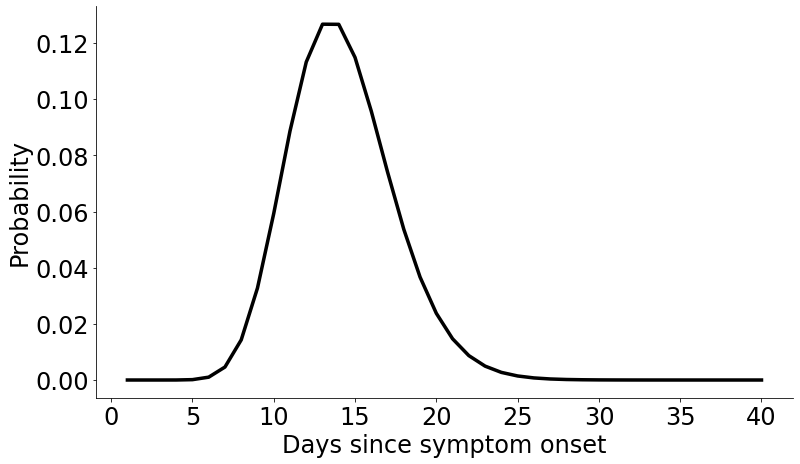

In [70]:
import matplotlib.pyplot as plt


si_dist(1/gamma_priors["omega"]).shape

fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))

ax.plot(np.arange(1, T)[:40], si_dist(1/gamma_priors["omega"])[:40], color="k", lw=3.5, label="Serial interval")
ax.set_xlabel("Days since symptom onset")
ax.set_ylabel("Probability")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

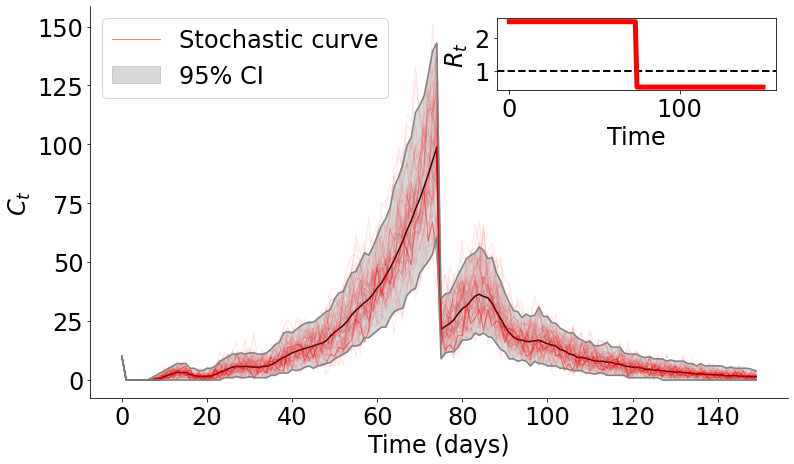

In [109]:

from mpl_toolkits.axes_grid.inset_locator import inset_axes


inf_df  = create_df_response(inf.T, T)

fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))
ax.plot(inf_df.index.values, inf_df['mean'], color="k")
ax.plot(inf_df.index.values, inf[:, np.random.randint(1,m, 50)], color="red", lw=1, alpha=0.1)
ax.plot(inf_df.index.values, inf[:, np.random.randint(1,m, 1)], color="red", lw=1, alpha=0.5, label="Stochastic curve")

ax.plot(inf_df.index.values, inf_df['low_95'], color="gray")
ax.plot(inf_df.index.values, inf_df['high_95'], color="gray")


ax.fill_between(inf_df.index.values, inf_df['low_50'], inf_df['high_50'], alpha=0.05, color="gray")
ax.fill_between(inf_df.index.values, inf_df['low_95'], inf_df['high_95'], alpha=0.3, color="gray", label="95% CI")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc="upper left")
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"$C_t$")


ax_inside = inset_axes(ax,
                    width="40%", # width = 30% of parent_bbox
                    height=1., # height : 1 inch
                    loc="upper right")

ax_inside.axhline(y=1, color="k", lw=2, ls="--")
ax_inside.plot(inf_df.index.values, Rt[:, 0], color="red", lw=5)
ax_inside.set_xlabel("Time")
ax_inside.set_ylabel(r"$R_{t}$")

fig.savefig("Figure1_renewal.png", dpi=300, transparent=True, bbox_inches='tight')

# Under-report distribution
Probability that a infection is being reported.


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_68367/1568265388.py:7: RuntimeWarning: divide by zero encountered in log
  pr = np.exp(np.log(x) * (a-1) + np.log(1-x) * (b-1) - np.log(factorial(a-1)) - np.log(factorial(b-1)) + np.log(factorial(a+b-1)))


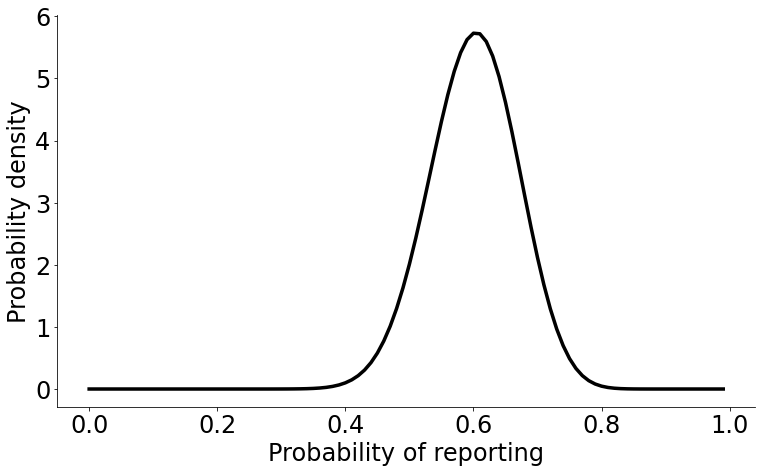

In [170]:
from scipy.special import factorial

def beta_dist(x, a, b):
    """
    Beta distribution
    """
    pr = np.exp(np.log(x) * (a-1) + np.log(1-x) * (b-1) - np.log(factorial(a-1)) - np.log(factorial(b-1)) + np.log(factorial(a+b-1)))
    return pr


def sample_report_probability(a, b, m):
    """
    Return m samples for report probability.
    """
    return np.random.beta(a, b, m)


# Mean of sampling distribution
rho = 0.6
b = 20
# Parameters of beta distribution
fr = rho/(1 - rho); a = fr*b

# Under-reporting distributionx
x        = np.arange(0, 1, 0.01)
beta_pdf = beta_dist(x, a, b)


fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))
ax.plot(x, beta_pdf, c="k", lw=3.5)

ax.set_xlabel("Probability of reporting")
ax.set_ylabel("Probability density")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("Under-ascertainmentDistribution.png", dpi=300, transparent=True, bbox_inches='tight')

In [145]:
from scipy.stats import beta



# Renewal model with R and serial interval densities
T        = 150
m        = 300
si_dist  = lambda p: gamma_dist(p, np.arange(1, T), gamma_priors["shape"])


# Constant R
Rt        = 2.5 *np.ones((T, m))
Rt[75:,:] = 0.5

# Daily incidence
inf  = np.zeros((T, m))

# Daily cases
case = np.zeros((T, m))

# Infectiousness, Poisson rate
λ    = np.zeros((T, m))
rate = np.zeros((T, m))

# Initialise epidemic
inf[0] = 10

N = 1e6
sus    = np.zeros((T, m))
sus[0] = N - inf[0]

rho_report = lambda m: sample_report_probability(a, b, m)

# Renewal model
for t in range(1, T):

    # Relevant part of serial distribution
    Pomegat = si_dist(1/gamma_priors["omega"])[:t]

    # Total infectiousness
    λ[t, :] =   np.dot(np.flip(inf[:t, :]).T, Pomegat)

    # Rate for ith day incidence
    rate[t, :] = λ[t, :] * Rt[t, :]

    # Renewal incidence

    # Renewal incidence
    inf[t, :]  = np.random.poisson(rate[t, :], m)
    case[t, :] = np.random.binomial(list(inf[t, :]), rho_report(m))


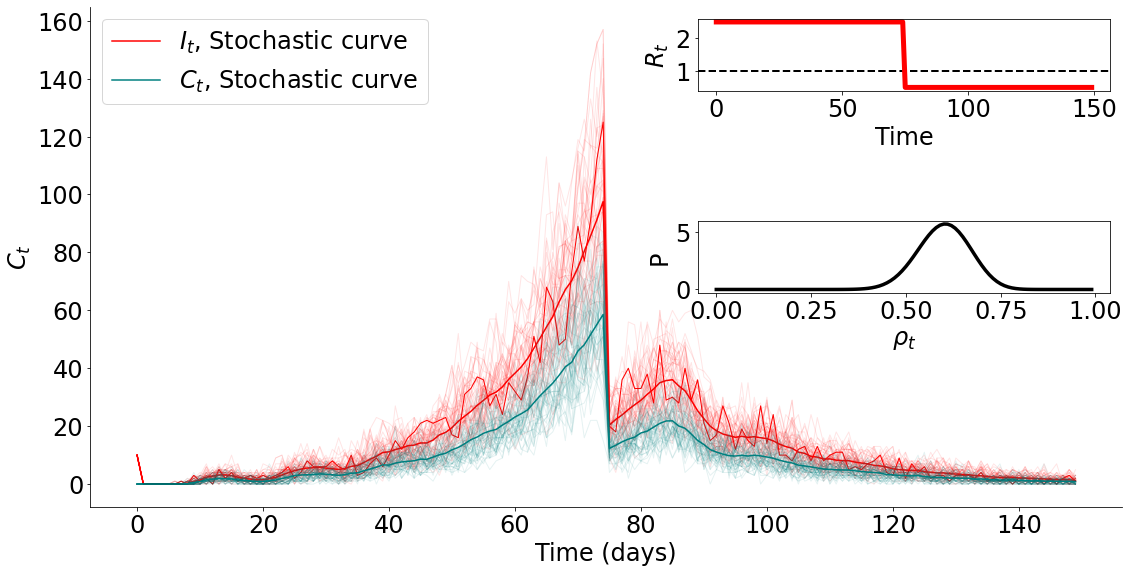

In [169]:

inf_df   = create_df_response(inf.T, T)
case_df  = create_df_response(case.T, T)

fig, ax = plt.subplots(1, 1, figsize=(18.5, 9.2))
ax.plot(inf_df.index.values, inf_df['mean'], color="red", label=r"$I_t$, Stochastic curve")
ax.plot(inf_df.index.values, inf[:, np.random.randint(1,m, 50)], color="red", lw=1, alpha=0.1)
ax.plot(inf_df.index.values, inf[:, np.random.randint(1,m, 1)], color="red", lw=1, alpha=1)

ax.plot(case_df.index.values, case_df['mean'], color="teal", label=r"$C_t$, Stochastic curve")
ax.plot(case_df.index.values, case[:, np.random.randint(1,m, 50)], color="teal", lw=1, alpha=0.1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc="upper left")
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"$C_t$")


ax_inside = inset_axes(ax,
                    width="40%", # width = 30% of parent_bbox
                    height=1., # height : 1 inch
                    loc="upper right")

ax_inside.axhline(y=1, color="k", lw=2, ls="--")
ax_inside.plot(inf_df.index.values, Rt[:, 0], color="red", lw=5)
ax_inside.set_xlabel("Time")
ax_inside.set_ylabel(r"$R_{t}$")


ax_inside = inset_axes(ax,
                    width="40%", # width = 30% of parent_bbox
                    height=1., # height : 1 inch
                    loc="center right")

ax_inside.plot(x, beta_pdf, c="k", lw=3.5)
ax_inside.set_ylabel("P")
ax_inside.set_xlabel(r"$\rho_t$")

fig.savefig("Figure2_Under-report.png", dpi=300, transparent=True, bbox_inches='tight')

## Distribution of delay
Delay from infection to case report is modelled (by the authors) as NegBinomial distribution, that they parametrize with the mean delay $T_d$

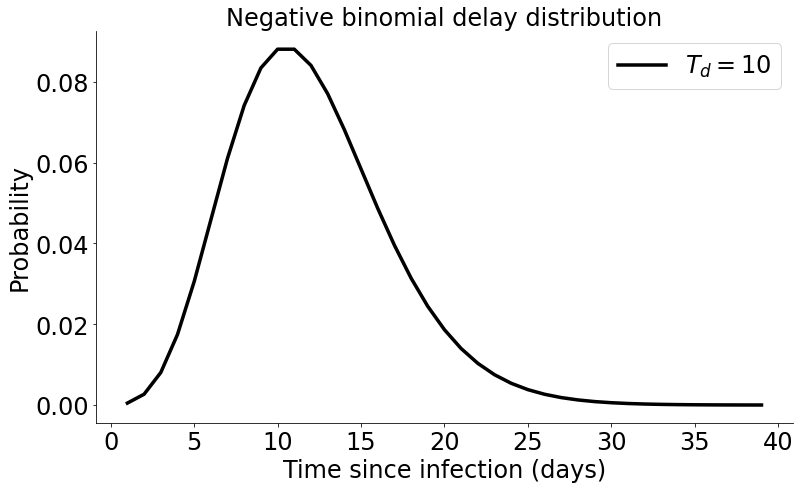

In [177]:
from re import L



def neg_binomial(x, r, p):
    """
    Negative binomial distribution
    """
    pr = np.zeros(x.shape)
    pr = factorial(x + r - 1) / (factorial(x - 1) * factorial(r)) * p**r * (1-p)**x
    return pr



# Mean of delay distribution
T_d = 10

# NegBin delay parameters
r       = 10
p_param = T_d/(r + T_d)

sample_nb = lambda pi:  np.random.default_rng().negative_binomial(r, pi, size=10000)

x = np.arange(1,40)
delay_05  = neg_binomial(x, r, p_param )


fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))
ax.plot(x, delay_05, c="k", lw=3.5, label=r"$T_d={}$".format(T_d))
ax.set_xlabel("Time since infection (days)")
ax.set_ylabel("Probability")
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Negative binomial delay distribution")


fig.savefig("DelayDistribution.png", dpi=300, transparent=True, bbox_inches='tight')

### Simulate Renewal Model with delay distribution

In [320]:
from scipy.stats import beta

# Renewal model with R and serial interval densities
T        = 150
m        = 300
si_dist  = lambda p: gamma_dist(p, np.arange(1, T), gamma_priors["shape"])


# Constant R
Rt        = 2.5 *np.ones((T, m))
Rt[75:,:] = 0.5

# Daily incidence
inf  = np.zeros((T, m))

# Daily cases
case = np.zeros((T, m))
case_d = np.zeros((T, m))

# Infectiousness, Poisson rate
λ      = np.zeros((T, m))
rate   = np.zeros((T, m))
rate_d = np.zeros((T, m))

# Initialise epidemic
inf[0] = 10

N = 1e6
sus    = np.zeros((T, m))
sus[0] = N - inf[0]

rho_report = lambda m: sample_report_probability(a, b, m)

delay_dist = neg_binomial(np.arange(1, T), r, p_param )

delay_d = neg_binomial(np.arange(1, T), r, p_param )


# Renewal model
for t in range(1, T):

    # Relevant part of serial distribution
    Pomegat = si_dist(1/gamma_priors["omega"])[:t]
    p_td    = neg_binomial(np.arange(t)+1, r, p_param )

    # Total infectiousness
    λ[t, :] =   np.dot(np.flip(inf[:t, :]).T, Pomegat)

    # Rate for ith day incidence
    rate[t, :]    = λ[t, :]  * Rt[t, :]
    rate_d[t, :] =  λ[t, :] * Rt[t, :]

    # Renewal incidence
    inf[t, :]    = np.random.poisson(rate[t, :], m)

    # Delayed incidence
    case[t, :] = np.random.poisson(np.dot(np.flip(delay_d[:t]).T, rate[:t, :]))


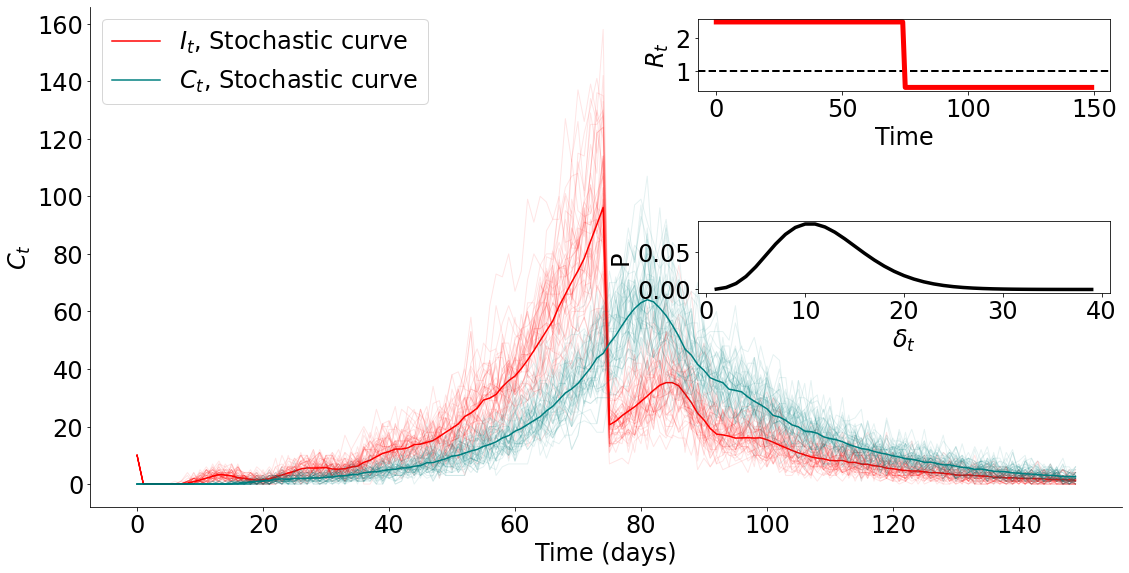

In [337]:

inf_df   = create_df_response(inf.T, T)
case_df  = create_df_response(case.T, T)

fig, ax = plt.subplots(1, 1, figsize=(18.5, 9.2))
ax.plot(inf_df.index.values, inf_df['mean'], color="red", label=r"$I_t$, Stochastic curve")
ax.plot(inf_df.index.values, inf[:, np.random.randint(1,m, 50)], color="red", lw=1, alpha=0.1)

ax.plot(case_df.index.values, case_df['mean'], color="teal", label=r"$C_t$, Stochastic curve")
ax.plot(case_df.index.values, case[:, np.random.randint(1,m, 50)], color="teal", lw=1, alpha=0.1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc="upper left")
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"$C_t$")


ax_inside = inset_axes(ax,
                    width="40%", # width = 30% of parent_bbox
                    height=1., # height : 1 inch
                    loc="upper right")

ax_inside.axhline(y=1, color="k", lw=2, ls="--")
ax_inside.plot(inf_df.index.values, Rt[:, 0], color="red", lw=5)
ax_inside.set_xlabel("Time")
ax_inside.set_ylabel(r"$R_{t}$")

ax_inside = inset_axes(ax,
                    width="40%",         # width = 30% of parent_bbox
                    height=1.,           # height : 1 inch
                    loc="center right")

ax_inside.plot(x, delay_05, c="k", lw=3.5, label=r"$T_d={}$".format(T_d))

ax_inside.set_ylabel("P")
ax_inside.set_xlabel(r"$\delta_t$")

fig.savefig("Figure3_Delay.png", dpi=300, transparent=True, bbox_inches='tight')